# Assignment 2

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel→→Restart) and then run all cells (in the menubar, select Cell→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [0]:
NAME = "Bhishek Manek"
STUDENT_ID = "1566863"

## Question 1 - Linear Regression

Inspiration for this question comes from: [1](https://mubaris.com/posts/linear-regression/) and [2](http://vxy10.github.io/2016/06/25/lin-reg-matrix/).

In this question, you will be implementing the linear regression algorithm from scratch in Python. As you know, linear regression aims to map feature vectors to a continuous value in the range $[-\infty,+\infty]$ by linearly combining the feature values.

### Model Representation
As you have seen previously in assignment 1, we represent our data as a dataframe or a feature matrix. 

Let our feature matrix be $X$ whose dimensions are $n \times m$, $\theta$ be a weight matrix of dimensions $m \times 1$, the bias vector $b$ a column vector of dimension $n\times 1$. Using these we can predict $\hat{Y}$
by the following relationship:

$$\hat{Y} = X\theta + b$$ 

(Does this look familiar? Remember $y = mx + b$)

### Data: Facebook posts metrics

This data contains features describing posts from a cosmetic brand's Facebook page. The authors use the following features: 

* Category,
* Page total likes: Number of people who have liked the company's page), 
* Type: Type of content (Link, Photo, Status, Video), 
* Post month: Month the post was published (January, February, March, …, December), 
* Post hour: Hour the post was published (0, 1, 2, 3, 4, …, 23) , 
* Post weekday: Weekday the post was published (Sunday, Monday, …,
Saturday) , 
* Paid: If the company paid to Facebook for advertising (yes, no)

to model: 

'Lifetime Post Total Reach', 'Lifetime Post Total Impressions', 'Lifetime Engaged Users', 'Lifetime Post Consumers',
'Lifetime Post Consumptions', 'Lifetime Post Impressions by people who have liked your Page', 'Lifetime Post reach by people who like your Page', 'Lifetime People who have liked your Page and engaged with your post', 'comment', 'like', 'share', 'Total Interactions'.


There are many possible features we could try to model, but we will focus on 'Total Interactions'. Our feature space will include: Category, Page total likes, Post month, Post hour, Post weekday, and Paid. We drop "Type" simply to avoid preprocessing.

You can read more about the dataset [here](http://archive.ics.uci.edu/ml/datasets/Facebook+metrics).






### Downloading the data

In [30]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip -O ./Facebook_metrics.zip
import zipfile
with zipfile.ZipFile('./Facebook_metrics.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2020-04-27 21:31:30--  http://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16281 (16K) [application/x-httpd-php]
Saving to: ‘./Facebook_metrics.zip’

./Facebook_metrics. 100%[===================>]  15.90K  --.-KB/s    in 0.1s    

2020-04-27 21:31:30 (115 KB/s) - ‘./Facebook_metrics.zip’ saved [16281/16281]



### Reading in data

In [31]:
import pandas as pd
import numpy as np
np.random.seed(37)
'''
Shuffles the data in place 
'''
def shuffle_data(data):
    np.random.shuffle(data)

# Read in the data
lr_dataframe = pd.read_csv('dataset_Facebook.csv',sep=';')
lr_dataframe.dropna(inplace=True)
columns_to_drop = ['Type','Lifetime Post Total Reach', 'Lifetime Post Total Impressions',
       'Lifetime Engaged Users', 'Lifetime Post Consumers',
       'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share']
lr_dataframe.drop(columns=columns_to_drop,inplace=True)

# Normalizing all remaining columns
def normalize_col(col):
    return (col - col.min())/(col.max() - col.min())

lr_dataframe = lr_dataframe.apply(normalize_col)

# Get entries as a numpy array
lr_data = lr_dataframe.values[:, :]

# Shuffle once for reproducibility
shuffle_data(lr_data)

lr_dataframe.head()

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Total Interactions
0,0.603830,1.0,0.363636,0.500000,0.545455,1.0,0.032049
1,0.626716,1.0,0.363636,0.333333,0.454545,0.0,0.017998
2,0.958310,0.5,0.818182,0.500000,0.090909,0.0,0.256710
3,0.830535,0.5,0.545455,0.666667,0.500000,1.0,0.047363
4,0.926883,0.0,0.727273,0.000000,0.136364,0.0,0.035523


### a) Splitting data in $X$ and $Y$
In this part we will write functions to split our data into a feature matrix X (augmented by a column of 1's to account for the bias term) and a column vector we wish to predict Y, shuffle our data, and finally further split X and Y into X_train, X_test, y_train and y_test for training and testing.

i) Split the dataset into $X$ and $Y$. In order to vectorize our calculations, we utilize the [bias trick](https://cs231n.github.io/linear-classify/). This simply means we need to append ones to our $X$ matrix. 

ii) Split $X$ and $Y$ into the training and test sets using the provided percentage split (default is 80\% training and 20\% test).

In [0]:
'''
Combines one column of all ones and the matrix X to account for the bias term 
(setting x_0 = 1) - [Hint: you may want to use np.hstack()]
Takes input matrix X
Returns the augmented input 
'''
def bias_trick(X):
  n = len(X)
  x_bias = np.ones((n,1))
  X = np.hstack((x_bias,X))
  return X

'''
Separates feature vectors and targets 
Takes raw data
Returns X as the matrix of feature vectors and Y as the vector of targets 
'''
def separate_data(data):
  data = bias_trick(data)
  split_data = np.hsplit(data,(data.shape[1]-1,data.shape[1]))
  X = split_data[0]
  Y = split_data[1]
  return X,Y
  
'''
Takes raw data in and splits the data into 
X_train, y_train, X_test, y_test
Returns X_train, y_train, X_test, y_test 
'''
def train_test_split(data, train_size=0.8):
  [X,Y] = separate_data(data)
  train_size_rows = int(train_size*len(X))
  X_train = X[:train_size_rows,:]
  Y_train = Y[:train_size_rows,:]
  X_test = X[train_size_rows:,:]
  Y_test = Y[train_size_rows:,:]
  
  return X_train,Y_train,X_test,Y_test

### b) Training and testing our model
**Refer to the following derivation of the gradient when implementing linear regression and gradient descent below.**

For this question, we'll use and implement the Mean Squared Error (MSE), and gradient descent algorithm. Suppose our dataset consists of $n$ records, each with $d$ features:

$$X =
\begin{bmatrix}
    x_{1,1}       & x_{1,2} & \cdots & x_{1,d} \\
    x_{2,1}       & x_{2,2} & \cdots & x_{2,d} \\
    \vdots       & \vdots & \ddots & \vdots \\
    x_{n,1}       & x_{n,2} & \cdots & x_{n,d}
\end{bmatrix}$$

One way to include a bias is to augment $X$ with a column of ones:

$$X =
\begin{bmatrix}
    1 & x_{1,1}       & x_{1,2} & \cdots & x_{1,d} \\
    1 & x_{2,1}       & x_{2,2} & \cdots & x_{2,d} \\
    \vdots  & \vdots & \vdots & \ddots & \vdots \\
    1 & x_{n,1}       & x_{n,2} & \cdots & x_{n,d}
\end{bmatrix}$$

We also have $n$ labels corresponding to the correct classification of each of the above records, $y=[y_1,y_2,\cdots ,y_{n}]^T$, i.e.:

$$y =
\begin{bmatrix}
    y_1  \\
    y_2  \\
    \vdots   \\
    y_{n} 
\end{bmatrix}$$

We will try to find the optimal parameter values $\theta = [\theta_0, \theta_1, \cdots, \theta_d]^T$ of our linear regression model, where $\theta_0$ is the bias weight. To simplify our notation, let
 
$$\hat{y} = X \theta =
\begin{bmatrix}
    X_{1,0}\theta_0 + X_{1,1}\theta_1 + \cdots + X_{1,d}\theta_d  \\
    X_{2,0}\theta_0 + X_{2,1}\theta_1 + \cdots + X_{2,d}\theta_d  \\
    \vdots   \\
    X_{n,0}\theta_0 + X_{n,1}\theta_1 + \cdots + X_{n,d}\theta_d 
\end{bmatrix} =
\begin{bmatrix}
    z_1  \\
    z_2  \\
    \vdots   \\
    z_{n}
\end{bmatrix}$$

We seek $\theta$ such that the MSE is minimized (the 1/2 factor makes the derivation easier). Let the MSE be a function of $\theta, J(\theta)$:

$$J(\theta) = \frac{1}{2n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$$

Since the above is a convex function, it has a unique minimum value. Taking the derivative with respect to $\theta_i$, we get:

$$\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{2n} \sum_{i=1}^{n} \frac{\partial}{\partial\theta_j}(\hat{y}_i - y_i)^2$$

$$\quad \quad \quad \quad= \frac{1}{n}\sum_{i=1}^{n} (\hat{y}_i - y_i) \frac{\partial}{\partial\theta_j} (\hat{y}_i)$$

Recall the chain rule from calculus, and that each $\hat{y}_i$ is a funcion of the $\theta_i$, so the above becomes:

$$\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{n} \sum_{i=1}^{n} ( \hat{y_i} - y_i)x_{i,j}$$

YOU SHOULD: 

i) Get training and testing set by calling train_test_split()

ii) Define a weight ($\theta$) vector

ii) Implement Gradient Descent using the information above

iii) Record the Sum Squared Error for training and test data

iv) Return the weight matrix, train errors and test errors

v) Plot the training and test errors and comment on the plot.

In [0]:
'''
Takes the target values and predicted values and calculates the absolute error 
between them 
'''
def mse(y_pred, y_true):
  n = len(y_pred)
  return 0.5 * (1/n) * np.sum((y_pred - y_true)**2)
    # YOUR CODE HERE

'''
Implementation of the derivative of MSE.
Returns a vector of derivations of loss with respect to each of the dimensions
[\partial loss / \partial \theta_i]
'''
def mse_derivative(X,y,theta):
  n = len(y)
  h = X @ theta
  return (1/n) * (np.transpose(X) @ (h-y))
    # YOUR CODE HERE

'''
Gradient descent step. 
Takes X, y, theta vector, and alpha. 
Returns an updated theta vector.
'''
def gradient_descent_step(X,y, theta, alpha):
  theta = theta - alpha * mse_derivative(X,y,theta)
  return theta #- alpha * mse_derivative(X,y,theta)


def linear_regression(data, num_epochs=30000, alpha=0.00005):
    # Get training and testing set by calling train_test_split()
    # YOUR CODE HERE
    [X_train,Y_train,X_test,Y_test] = train_test_split(data)

    # Record training and test errors in lists
    train_errors= []
    test_errors= []

    # Define theta
    theta = np.zeros((X_train.shape[1],1))
    #print(theta)

    # Carry out training loop
    for i in range(num_epochs):
        y_pred_train = X_train @ theta
        train_error = mse(y_pred_train, Y_train)
        train_errors.append(train_error)
        # YOUR CODE HERE

        y_pred_test = X_test @ theta
        test_error = mse(y_pred_test,Y_test)
        test_errors.append(test_error)

        # Do gradient descent on the training set
        theta = gradient_descent_step(X_train,Y_train,theta,alpha)
        # YOUR CODE HERE
    return theta, train_errors, test_errors

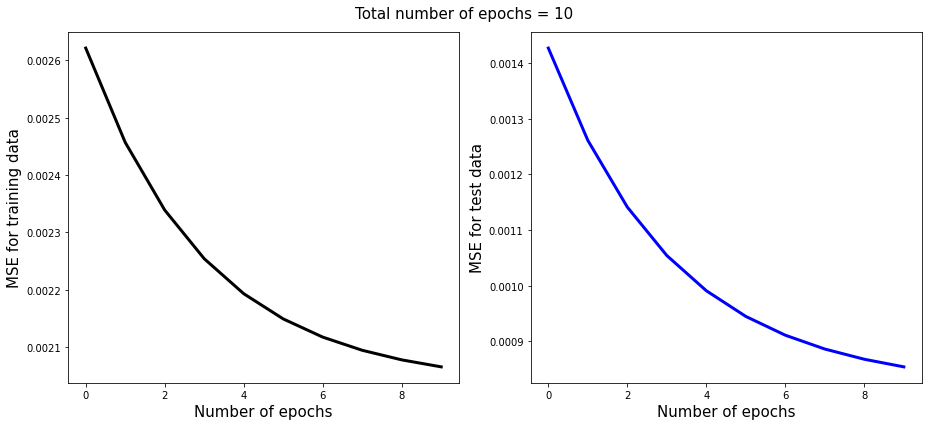

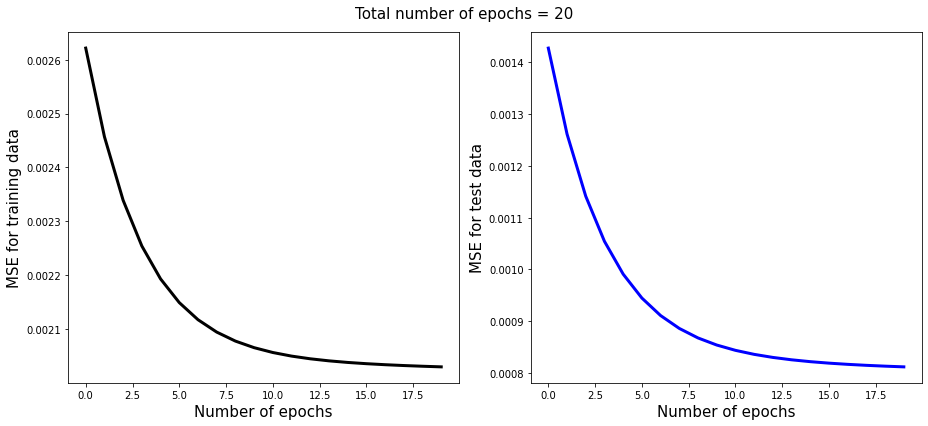

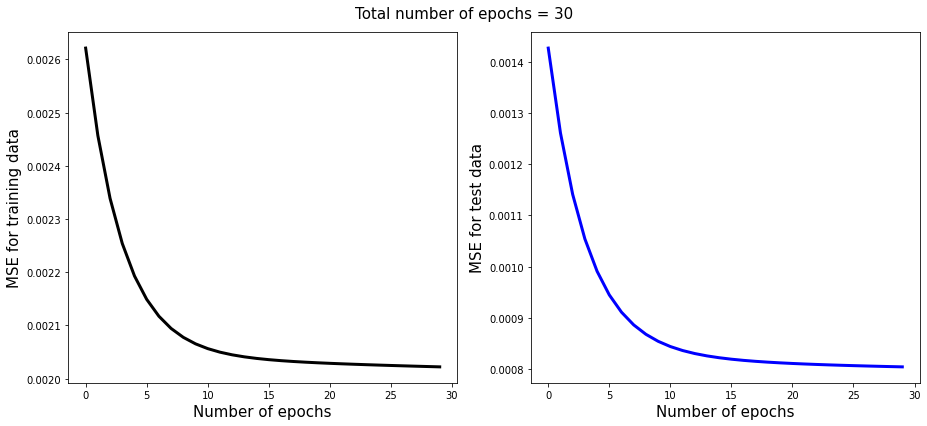

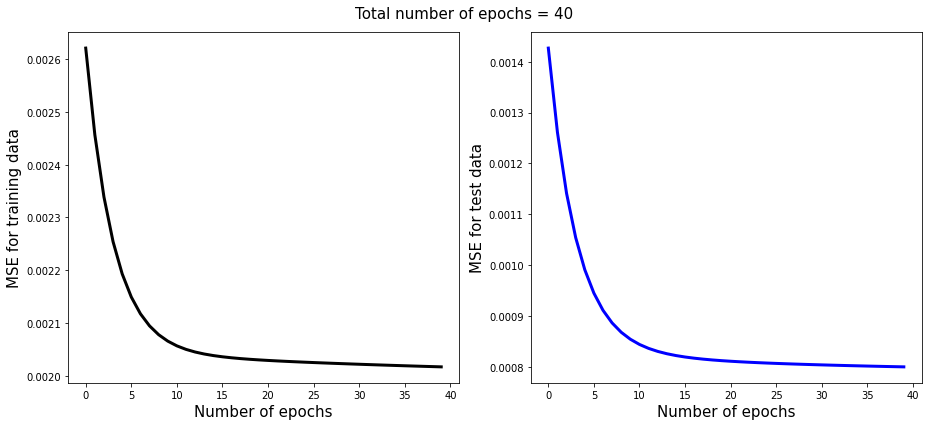

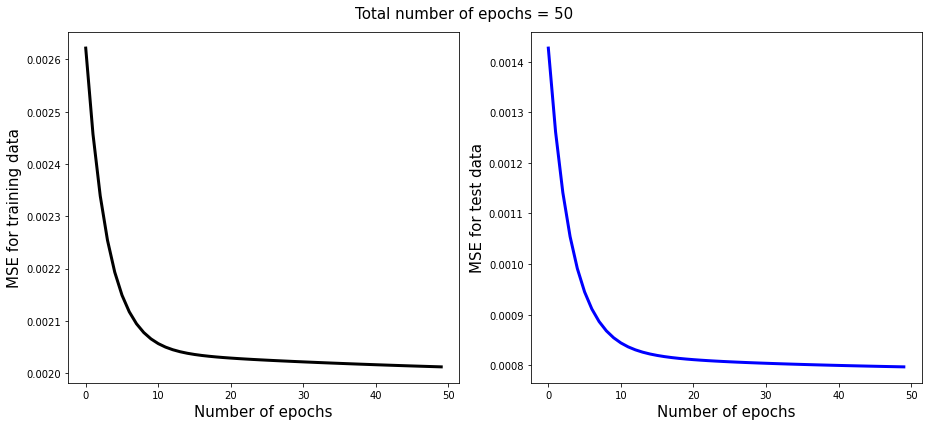

In [35]:
# Carry out training task
# YOUR CODE HERE
# Training task is done for a number of epochs for a particular alpha
# Variables to look for - i, num_epochs, alpha and text_val (for proper annotation of the title of the plot)

import matplotlib.pyplot as plt
for i in range(1,6):

  [theta,train_errors,test_errors] = linear_regression(lr_data,num_epochs=i*10,alpha=0.06)
  
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,6))
  
  # Subplot 1 for training errors
  ax1.plot(train_errors,linewidth=3,color='black')
  ax1.set_xlabel('Number of epochs', fontsize=15)
  ax1.set_ylabel('MSE for training data', fontsize=15)

  # Subplot 2 for test errors
  ax2.plot(test_errors,linewidth=3,color='blue')
  ax2.set_xlabel('Number of epochs', fontsize=15)
  ax2.set_ylabel('MSE for test data', fontsize=15)

  # Change text_val below appropriately if multiple of no. of epochs change
  text_val = str(i*10)
  fig.suptitle('Total number of epochs = ' + text_val, fontsize=15)
  fig.tight_layout()
  fig.subplots_adjust(top=0.92)
  plt.show()

### c) How did we do?

Please comment on the performance of the model you trained on training and test sets.

#### YOUR ANSWER HERE
On trying out linear regression on the given dataset with different learning rates ($\alpha$), I found that $\alpha \sim 0.6-0.7$ is the largest possible learning rate for which there is convergence in the values of $\theta$. For this range of $\alpha$, the convergence is very quick and only $10-20$ epochs are required. 

I also consistently have higher mean squared error for training data as compared to test data. From the discussions in Piazza, I learnt that this is not usually the case and test error is expected to be higher or atleast comparable to the training data error. However, looking at the normalized data closely, the "total interaction" column has a mean value of around $0.03$ and one of the entries has a maximum of $1.0$. This particular entry is part of the training data (for the given random number and after shuffling) and leads to this higher error in the MSE for training data. 

Some obvsious conclusion on the performance of the model is that it takes higher number of epochs for a small learning rate, $\alpha$, to achieve convergence. The best performance as stated above is for $\alpha \sim 0.6-0.7$ which requires only about $10-20$ epochs for convergence. 

**Note**: The default setup at the time of submission of assignment is with $\alpha=0.06$ which requires about $30-40$ epochs for proper convergence.

## Question 2
---
### Fitting non-linear data

Data may not follow a linear relationship from the independent variable $X$ to the dependent variable $y$. Fitting a linear model to this would be inaccurate and yield a high loss. 

If we want to model an order $d$ polynomial relationship between $X$ and $y$ we can augment our initial linear model where instead of having:
$$
y_i = \theta_0 + \theta_1 x_i
$$

We have:

$$
y_i = \theta_0 + \theta_1 x_i + \theta_2 x_i^2 + \cdots + \theta_d x_i^d
$$

We can use the same linear regression algorithm we if we first augment $X$ and add extra columns (or dimensions). 

$$ \textbf X =
\begin{bmatrix}
    x_{1}       & x_{1}^2 & \cdots & x_{1}^d \\
    x_{2}       & x_{2}^2 & \cdots & x_{2}^d \\
    \vdots       & \vdots & \ddots & \vdots \\
    x_{n}       & x_{n}^2 & \cdots & x_{n}^d
\end{bmatrix}$$

Then our new higher order $\hat y$ is computed same as before.

$$ \hat y =  X \theta =
\begin{bmatrix}
    1 & x_{1}       & x_{1}^2 & \cdots & x_{1}^d \\
    1 & x_{2}       & x_{2}^2 & \cdots & x_{2}^d \\
    \vdots & \vdots       & \vdots & \ddots & \vdots \\
    1 & x_{n}       & x_{n}^2 & \cdots & x_{n}^d
\end{bmatrix}
\begin{bmatrix}\theta_0 \\ \theta_1 \\ \vdots \\ \theta_{d} 
\end{bmatrix}=
\begin{bmatrix}
    \theta_0 + \theta_1 x_{1} + \theta_2 x_{1}^2 + \cdots + \theta_{d}  x_{1}^d \\
    \theta_0 + \theta_1 x_{2} + \theta_2 x_{2}^2 + \cdots + \theta_{d}  x_{2}^d  \\
    \vdots   \\
    \theta_0 + \theta_1 x_{n} + \theta_2 x_{n}^2 + \cdots + \theta_{d}  x_{n}^d
\end{bmatrix} 
= \begin{bmatrix}\hat y_1 \\ \hat y_2 \\ \vdots \\ \hat y_{n} 
\end{bmatrix}$$






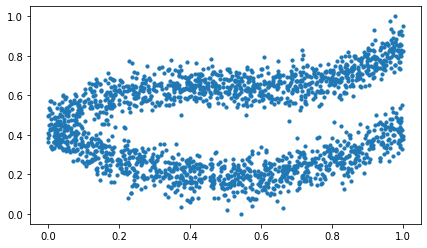

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_data(data):
    return (data - np.min(data))/(np.max(data) - np.min(data))

np.random.seed(33)
x = np.random.uniform(-10, 10, 1000)
poly_coeffs = np.random.uniform(-1,1, size=(4,1))
y = poly_coeffs[0] + poly_coeffs[1]*x + poly_coeffs[2]*(x ** 2) + poly_coeffs[3]*(x ** 3) + np.random.normal(0, 250, 1000)

x2 = np.random.uniform(-10, 10, 1000)
poly_coeffs = np.random.uniform(-1,1, size=(3,1))
y2 = poly_coeffs[0] - 2000 + poly_coeffs[1]*x2 + 50*poly_coeffs[2]*(x2 ** 2)  + np.random.normal(0, 250, 1000)

x = np.concatenate([x,x2])
y = np.concatenate([y,y2])
x = normalize_data(x)
y = normalize_data(y)

plt.scatter(x,y, s=10)
plt.show()

poly_data = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
np.random.shuffle(poly_data)
x = poly_data[:,0]
y = poly_data[:,1]

In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [0]:
reg = LinearRegression().fit(x.reshape(-1,1), y)

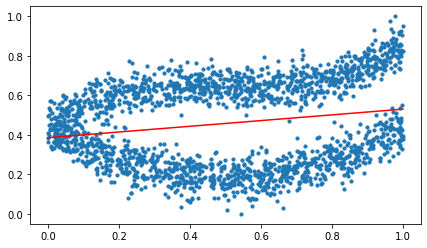

In [39]:
def compute_line_from_regr(X_data, y_data, regr):
    l_bound = np.min(X_data)
    r_bound = np.max(X_data)
    return [l_bound, r_bound], [l_bound * regr.coef_ + regr.intercept_, r_bound * regr.coef_ + regr.intercept_]

plt.scatter(x,y, s=10)
line_x, line_y = compute_line_from_regr(x.reshape(-1,1),y,reg)
plt.plot(line_x, line_y, color='r')
plt.show()

As we see above, this data doesn't follow a linear relationship, it follows some complex polynomial. In the next section you'll try to fit a higher degree polynomial to it.

## Weight regularization
When we try to fit a d-order polynomial to our data, we could end up overfitting. This happens when you try to fit a higher dimensional curve than what the distribution of our data actually exhibits. We can mitigate this by choosing an order $d$ that matches your data closely, but often times this is not directly apperant in noisy data. Another method to avoid overfitting is **regularizing**, where you modify your loss to keep weights small which flattens our polynomial. This helps us avoid learning polynomials that are too complex for our data.

To add regularization we modify our original loss function $J$ to include our regularizing term and a new hyperparameter that we tune $\lambda$. This controls the amount of regularizing we impose on the weights. We use the loss computed from the validation set to tweak this parameter.

$$
J(\theta)=\frac{1}{2n}\sum^{n}_{i=1}(h^{(i)}-y^{(i)})^2 + \lambda \sum^{d}_{j=1} \theta^2_j
$$

Our gradient computation also changes:

$$
\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{n} \sum_{i=1}^{n} ( h^{(i)}-y^{(i)})x_{i,j}  + 2 \lambda\theta_j 
$$

We apply this gradient the same way as before in our gradient descent algorithm:
$$
 \theta_j = \theta_j - \alpha \frac{\partial}{\partial\theta_j}J(\theta)
$$

In [0]:
'''
Takes raw data in and splits the data into 
X_train, y_train, X_test, y_test, X_val, y_val
Returns X_train, y_train, X_test, y_test, X_val, y_val
'''
def train_test_validation_split(data, test_size=.20, validation_size=.20):

  # Separate_data adds bias to the input data matrix and returns X and Y separated
  [X,Y] = separate_data(data)
  train_size_rows = int((1-test_size-validation_size)*len(X))
  test_size_rows = int(test_size*len(X))
  validation_size_rows = len(X) - train_size_rows - test_size_rows
  X_train = X[:-test_size_rows-validation_size_rows,:]
  Y_train = Y[:-test_size_rows-validation_size_rows,:]
  X_test = X[-test_size_rows:,:]
  Y_test = Y[-test_size_rows:,:]
  X_val = X[-test_size_rows-validation_size_rows:-test_size_rows,:]
  Y_val = Y[-test_size_rows-validation_size_rows:-test_size_rows,:]

  return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [0]:
'''
Adds columns to your data up to the specified degree.
Ex: If degree=3, (x) -> (x, x^2, x^3)
'''
def add_polycols(X,degree):
    x_col = X[:,-1]

    for i in range(2, degree+1):
        X = np.hstack((X,(x_col**i).reshape(-1,1)))
    return X

'''
Takes the target values and predicted values and calculates the absolute error 
between them 
'''
def mse(y_pred, y_true):
  n = len(y_pred)
  return 0.5 * (1/n) * np.sum((y_pred - y_true)**2)
    # YOUR CODE HERE
    # Feel free to use your implementation from Q1
    

'''
Implementation of the derivative of MSE.
Returns a vector of derivations of loss with respect to each of the dimensions
[\partial loss / \partial \theta_i]
'''
def mse_derivative(X,y,theta):
  n = len(y)
  h = X @ theta
  return (1/n) * (np.transpose(X) @ (h-y))
    # YOUR CODE HERE
    # Feel free to use your implementation from Q1

'''
Computes L2 norm from theta and lambda.
Returns a scalar of L2 norms.
'''
def l2norm(theta, lamb):
  theta1 = theta.copy()
  theta1[0] = 0
  #print(theta1)
  return lamb * np.sqrt(np.transpose(theta1) @ theta1)

'''
Computes derivative of L2 norm.
Returns a vector of derivative of L2 norms.
'''
def l2norm_derivative(theta, lamb):
  theta1 = theta.copy()
  theta1[0] = 0
  return 2*lamb*theta1

'''
Computes total cost (cost function + regularization term)
'''
def compute_cost(X, y, theta, lamb):
  cost_func_old = mse(X @ theta,y)
  cost_func_reg = l2norm(theta,lamb)
  cost = cost_func_old + cost_func_reg
  return cost

'''
Gradient descent step. 
Takes X, y, theta vector, and alpha. 
Returns an updated theta vector.
'''
def gradient_descent_step(X, y, theta, alpha, lamb):
  theta = theta - alpha * (mse_derivative(X, y, theta) + l2norm_derivative(theta, lamb))
  return theta


def polynomial_regression(data, degree, num_epochs=100000, alpha=1e-4, lamb=0):
    # Get training, testing, and validation sets by calling train_test_validation_split()
    [X_train,Y_train,X_test,Y_test,X_val,Y_val] = train_test_validation_split(data)

    # Record training and validation errors in lists
    train_errors = []
    val_errors = []

    # Add the appropriate amount of columns to each of your sets of data.
    X_train = add_polycols(X_train, degree)
    X_val = add_polycols(X_val, degree)
    X_test = add_polycols(X_test, degree)

    # Define theta
    theta = np.zeros((X_train.shape[1]))
    theta = theta.reshape(-1,1)

    # Carry out training loop

    for i in range(num_epochs):

        # Calculate training error
        y_pred_train = X_train @ theta
        train_error = compute_cost(X_train, Y_train, theta, lamb)

        train_errors.append(train_error)

        # Calculate calidation error
        y_pred_val = X_val @ theta
        val_error = compute_cost(X_val, Y_val, theta, lamb)

        val_errors.append(val_error)
        
        # Do gradient descent on the training set
        theta = gradient_descent_step(X_train, Y_train, theta, alpha, lamb)

        # This prints the validation loss
        if i % (num_epochs//10) == 0:
            print(f'({i} epochs) Training loss: {train_error}, Validation loss: {val_error}') 
    print(f'({i} epochs) Final training loss: {train_error}, Final validation loss: {val_error}') 
    
    # Compute the testing loss
    y_pred_test = X_test @ theta
    test_error = compute_cost(X_test, Y_test, theta, lamb)
     
    print(f'Final testing loss: {test_error}')
    return theta, train_errors, val_errors

As we mentioned above, we use the validation set's loss to tweak our hyperparameters. Please carry out the training task while monitoring the validation loss and varying the polynomial order $d$ and regularization constant $\lambda$. Your answer should get close to minimizing the validation and testing losses. 

In [95]:
# degree d
polynomial_order = 3

# regularization constant lambda
regularization_param = 0.0001

theta, train_errors, val_errors = polynomial_regression(poly_data, polynomial_order, lamb=regularization_param, num_epochs=3000, alpha=0.5)

(0 epochs) Training loss: [[0.1312608]], Validation loss: [[0.12391363]]
(300 epochs) Training loss: [[0.02142951]], Validation loss: [[0.02102981]]
(600 epochs) Training loss: [[0.02136879]], Validation loss: [[0.02088095]]
(900 epochs) Training loss: [[0.02136116]], Validation loss: [[0.02084179]]
(1200 epochs) Training loss: [[0.02135994]], Validation loss: [[0.02082824]]
(1500 epochs) Training loss: [[0.02135944]], Validation loss: [[0.02082218]]
(1800 epochs) Training loss: [[0.02135903]], Validation loss: [[0.02081865]]
(2100 epochs) Training loss: [[0.02135865]], Validation loss: [[0.02081607]]
(2400 epochs) Training loss: [[0.0213583]], Validation loss: [[0.0208139]]
(2700 epochs) Training loss: [[0.02135799]], Validation loss: [[0.02081193]]
(2999 epochs) Final training loss: [[0.0213577]], Final validation loss: [[0.02081012]]
Final testing loss: [[0.02118026]]


In [0]:
# Call plot_results() to see how your polynomial fits.
def plot_results(theta, X, Y):
    y_hat = sum([t*X**i for i,t in enumerate(theta)])
    plt.scatter(X, y_hat, s=10, color='r')
    plt.scatter(X, Y, s=10)
    plt.show()

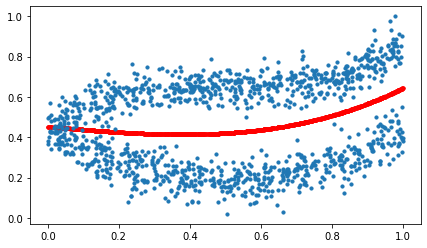

In [96]:
# Calling train_test_validation to get all the X and Y data 
# No need to do add_polycols as that is taken care inside plot_results

[X_train,Y_train,X_test,Y_test,X_val,Y_val] = train_test_validation_split(poly_data)

plot_results(theta, X_train[:,1], Y_train)

**Note**: 
1. The role of regularization is not really important for this particular dataset. Even when regularization parameter = 0, I was able to obtain a good fit to the above data. 
2. I also changed the learning rate (and num_epochs) from the default one that was provided. I have chosen to keep the learning rate at 0.5. Even higher learning rate is possible and would lead to even faster convergence to optimal $\theta$ values. 